# SARIMAX
STATIONARY TESTS TIME SERIES FOR FRESNO DATA

## Acquire Data

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


In [168]:
filename = "data/ac_output.csv"
output = pd.read_csv(filename)

In [169]:
output.index = pd.to_datetime(output['datetime'])
daily_output = output['0'].resample('W').sum()
#daily_output.to_csv('daily_output.csv')
daily_output = daily_output.reset_index()
daily_output.columns = ['datetime', 'initial']

date = pd.DataFrame(daily_output['datetime'])

## Stationary Tests


Augmented Dickey-Fuller Test:
Test Statistic: -10.5565
p-value: 0.0000
Critical Values:
	1%: -3.4355
	5%: -2.8638
	10%: -2.5680

KPSS Test:
Test Statistic: 0.0458
p-value: 0.1000


C:\Users\naoki\AppData\Local\Temp\ipykernel_30372\3749740444.py:47: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries.dropna())


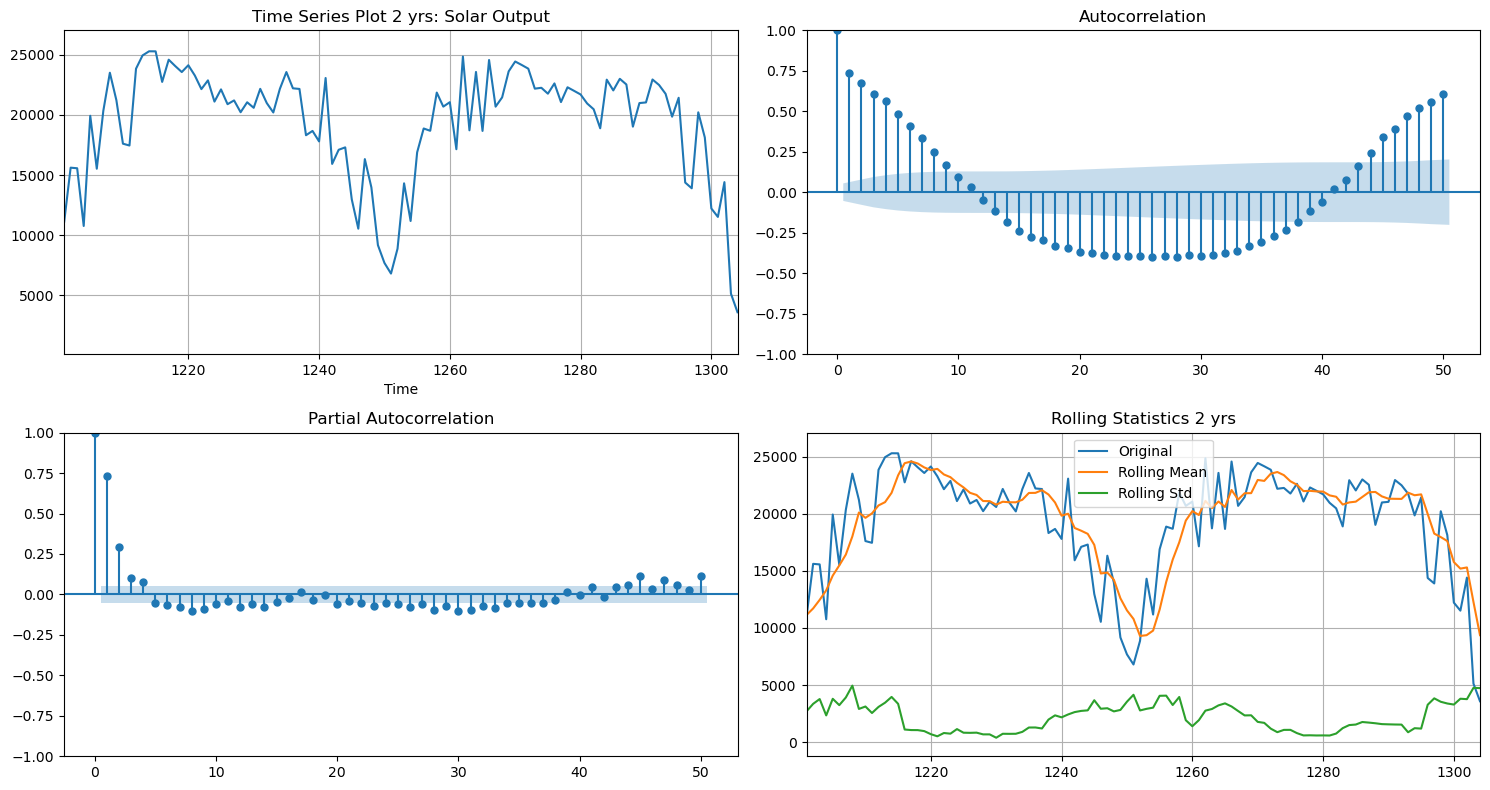

In [170]:

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def check_stationarity(timeseries, title='', lag=50):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
    
    # Time series plot
    ax1.plot(timeseries)
    ax1.set_title(f'Time Series Plot 2 yrs: {title}')
    ax1.set_xlabel('Time')
    ax1.set_xlim([timeseries.index[-104], timeseries.index[-1]])
    ax1.grid(True)
    
    # ACF plot 
    plot_acf(timeseries, ax=ax2,lags=lag, title='Autocorrelation')
      
    
    # PACF plot 
    plot_pacf(timeseries, ax=ax3,lags=lag, title='Partial Autocorrelation')
      
    
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=5).mean()
    rolling_std = timeseries.rolling(window=5).std()
    ax4.plot(timeseries, label='Original')
    ax4.plot(rolling_mean, label='Rolling Mean')
    ax4.plot(rolling_std, label='Rolling Std')
    ax4.set_title('Rolling Statistics 2 yrs')
    ax4.legend()
    ax4.set_xlim([timeseries.index[-104], timeseries.index[-1]])
    ax4.grid(True)
    
    plt.tight_layout()
    
    # ADF Test
    adf_result = adfuller(timeseries.dropna())
    print('\nAugmented Dickey-Fuller Test:')
    print(f'Test Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value:.4f}')
    
    # KPSS Test
    kpss_result = kpss(timeseries.dropna())
    print('\nKPSS Test:')
    print(f'Test Statistic: {kpss_result[0]:.4f}')
    print(f'p-value: {kpss_result[1]:.4f}')


check_stationarity(daily_output['initial'], 'Solar Output')


Dickey Fuller Test Findings: Reject Null hypothesis of non-stationarity. 



Time Series Plot findings: Seasonal patterns. 

ACF Plot findings : Strong positive 1st lag Autocorrelation, medium strength long term autocorrelations . Slow decay = non-stationary

PACF Plot findings: Strong short term autocorrelation

Rolling Statistics Plot Findings: Std significantly rises during winter months. Variation is seasonality. Need for GARCH model



## Transformation of data to stationary

Data Follows yearly seasonal pattern. Difference by 1 year and 1 period.
APPLY DIFFERENCING 2nd order

In [171]:
daily_output['1pd'] = daily_output['initial'].diff(periods=1)
daily_output['seasonal'] = daily_output['initial'].diff(periods=52)


daily_output['differenced'] = daily_output['initial'].diff(periods=52)
daily_output['differenced'] = daily_output['differenced'].diff(periods=1)

2 Yrs of 2 differenced plot

## Test For Stationarity AGAIN


Augmented Dickey-Fuller Test:
Test Statistic: -12.3115
p-value: 0.0000
Critical Values:
	1%: -3.4357
	5%: -2.8639
	10%: -2.5680

KPSS Test:
Test Statistic: 0.0272
p-value: 0.1000


C:\Users\naoki\AppData\Local\Temp\ipykernel_30372\3749740444.py:47: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries.dropna())


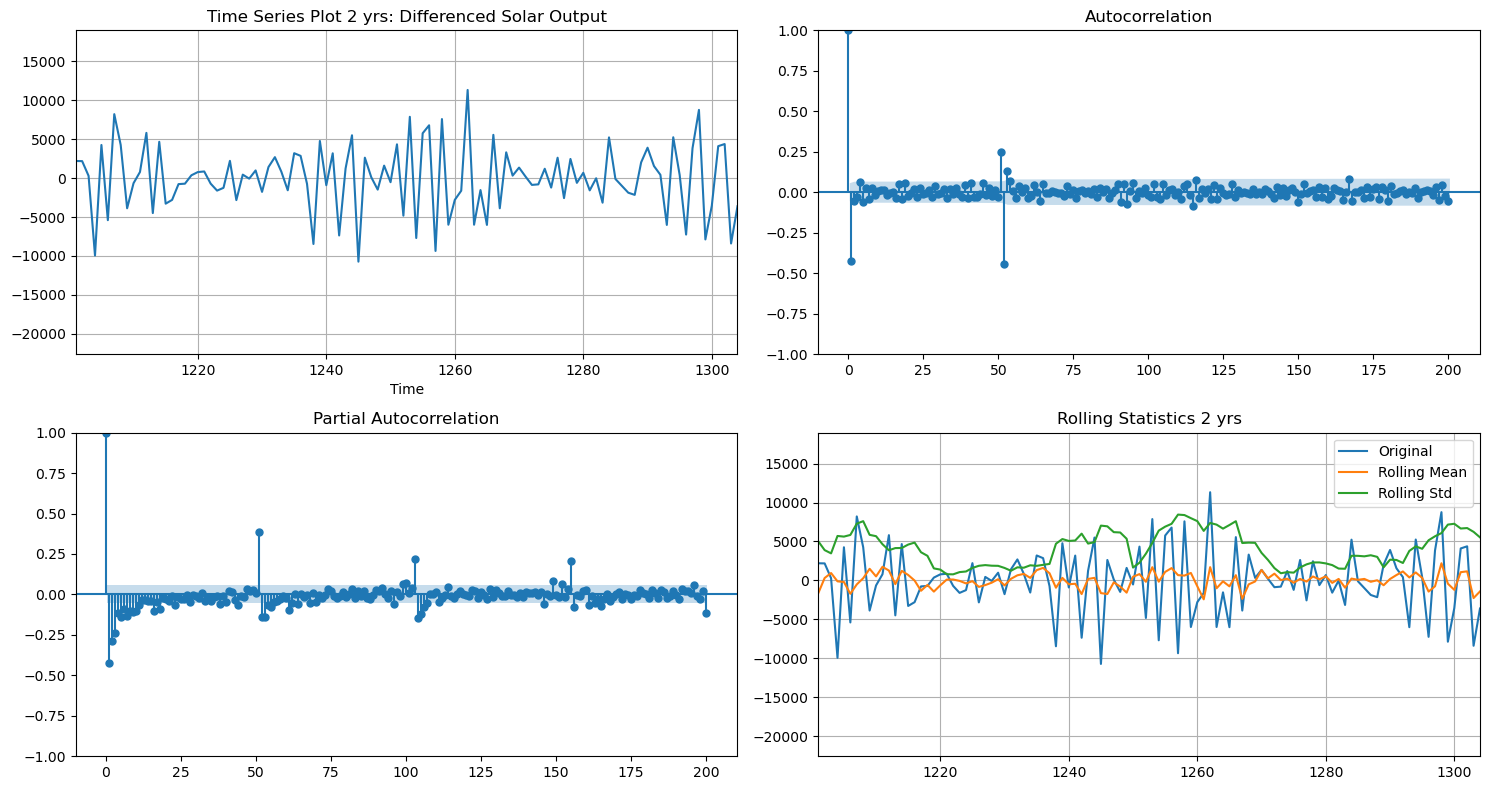

In [222]:
check_stationarity(daily_output['differenced'].dropna(), 'Differenced Solar Output',lag=200)

Autocorrelations now mostly stay inside of confidence intervals. Suggests no reason to reject Null

## Decomposition of line----supplementary analysis


In [173]:
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


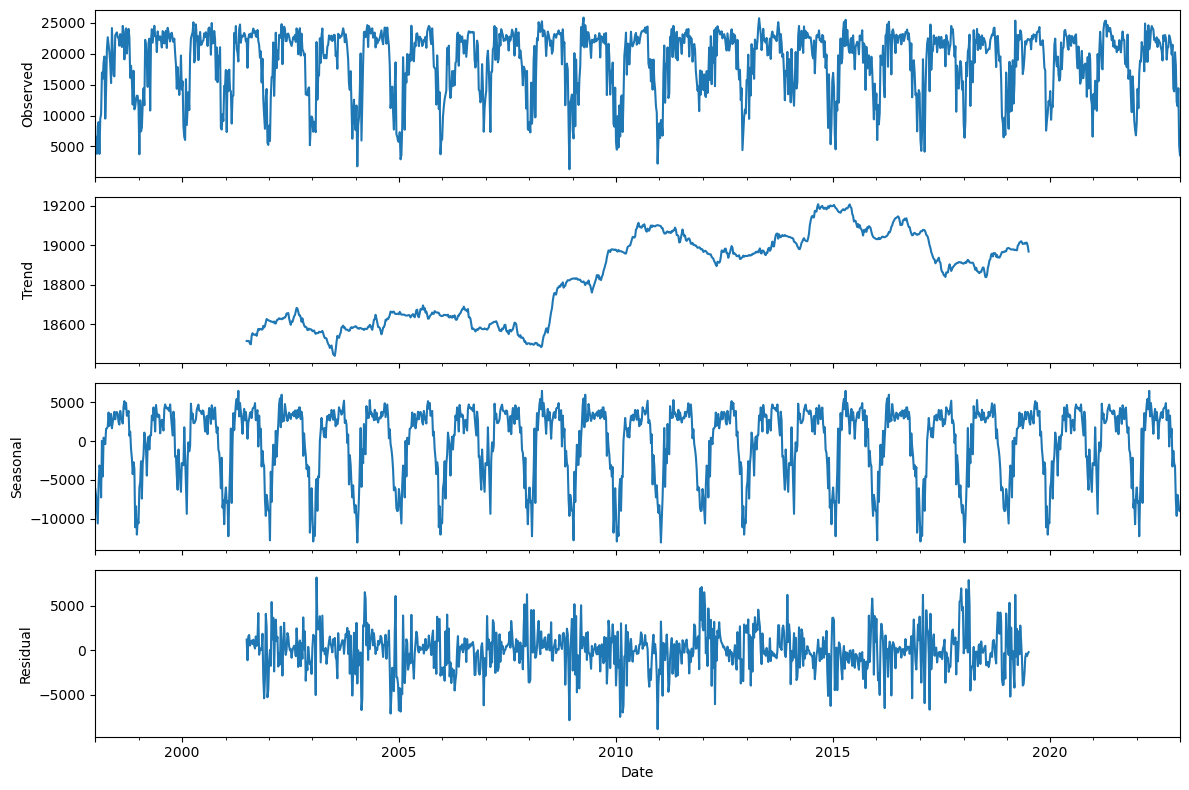

In [174]:
WINDOW_SIZE = 365   

result = seasonal_decompose(daily_output['initial'], model='additive', period=WINDOW_SIZE)
daily_output['Residual'] = result.resid
# Set the datetime index for the decomposed components
result.trend.index = daily_output['datetime']
result.seasonal.index = daily_output['datetime']
result.resid.index = daily_output['datetime']
result.observed.index = daily_output['datetime']

# Plot the decomposed components with dates on the x-axis
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')
plt.tight_layout()


C:\Users\naoki\AppData\Local\Temp\ipykernel_30372\4288516415.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result.trend[daily_output_2010.index].plot(ax=axes[1], legend=False)
C:\Users\naoki\AppData\Local\Temp\ipykernel_30372\4288516415.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result.seasonal[daily_output_2010.index].plot(ax=axes[2], legend=False)
C:\Users\naoki\AppData\Local\Temp\ipykernel_30372\4288516415.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

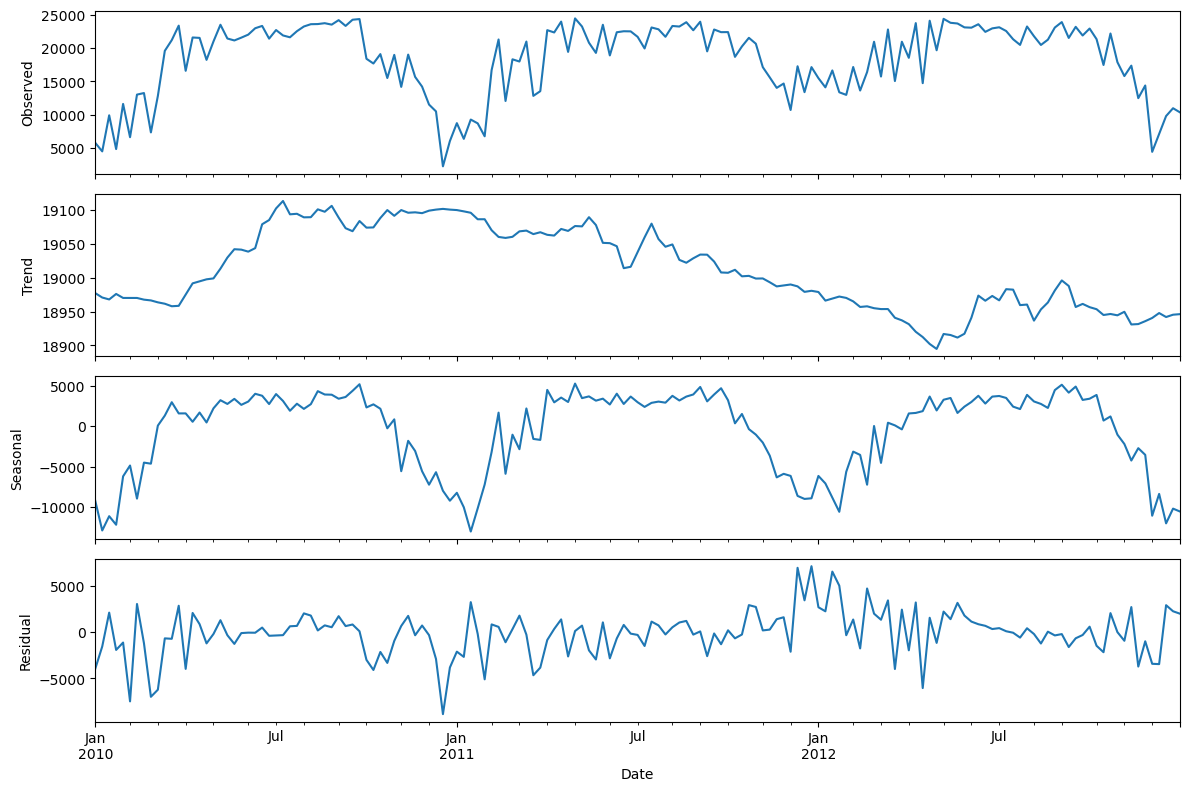

In [175]:
# Filter data for the year 2010
daily_output_2010 = daily_output[(daily_output['datetime'] >= '2010-01-01') & (daily_output['datetime'] <= '2012-12-31')]

# Plot the decomposed components for the year 2010
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
daily_output_2010.set_index('datetime')['initial'].plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend[daily_output_2010.index].plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal[daily_output_2010.index].plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid[daily_output_2010.index].plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')
plt.tight_layout()
plt.show()

We see it isolates a clear seasonal component but also that the residuals are autocorrelated and skewed

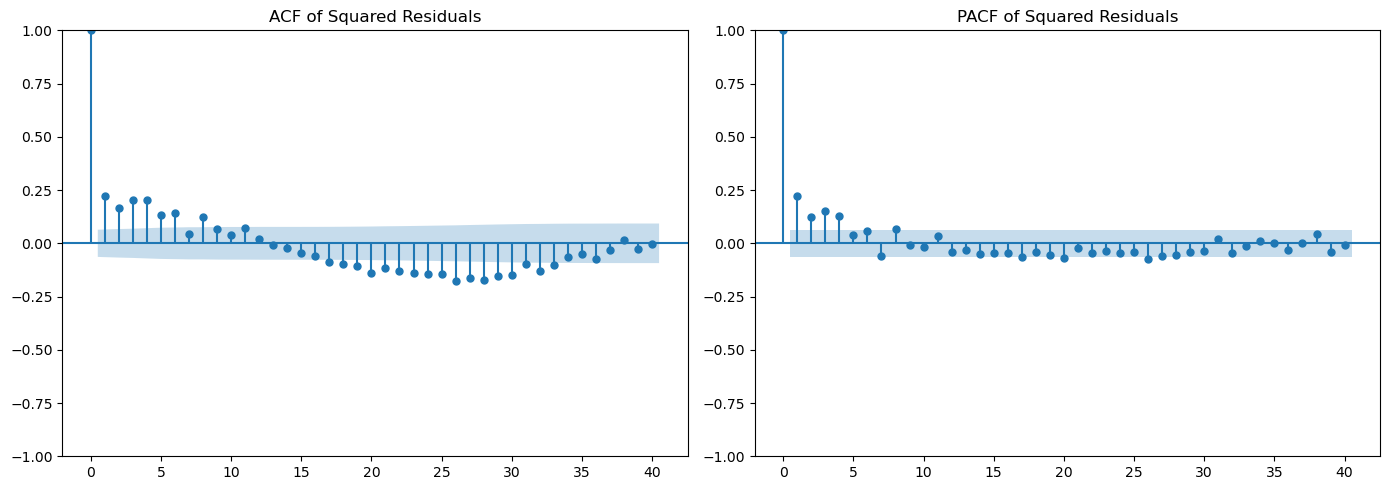

In [176]:
residuals_no_nan = daily_output['Residual'].dropna()

# Calculate squared residuals
squared_residuals = residuals_no_nan**2

# Plot ACF and PACF of squared residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(squared_residuals, lags=40, ax=axes[0])
axes[0].set_title('ACF of Squared Residuals')

plot_pacf(squared_residuals, lags=40, ax=axes[1])
axes[1].set_title('PACF of Squared Residuals')

plt.tight_layout()
plt.show()

Interpreting the Plots:

- ACF of Squared Residuals:
   - Significant Autocorrelations: If you see significant autocorrelations (bars extending beyond the shaded confidence interval) in the ACF of the squared residuals, it indicates that there is heteroscedasticity (changing variance) in the residuals. The lags at which these significant autocorrelations occur suggest the order of the ARCH component (p) in a GARCH model.  From the plot it is clear that the squared residuals are correlated with their past values, meaning that periods of high volatility are likely to be followed by periods of high volatility, and vice-versa.

    

- PACF of Squared Residuals:
   - Significant Partial Autocorrelations: Similar to the ACF, significant partial autocorrelations in the PACF of the squared residuals also indicate heteroscedasticity. The PACF helps to determine the order of the GARCH component (q) in a GARCH model. In the plot we see significant partial autocorrelations primarily at lags 1, 2, 3, and 4. This further confirms the presence of heteroscedasticity. Pattern: The PACF, like the ACF, also shows a few significant lags and then a relatively quick decay. 

This justifies using a GARCH model.





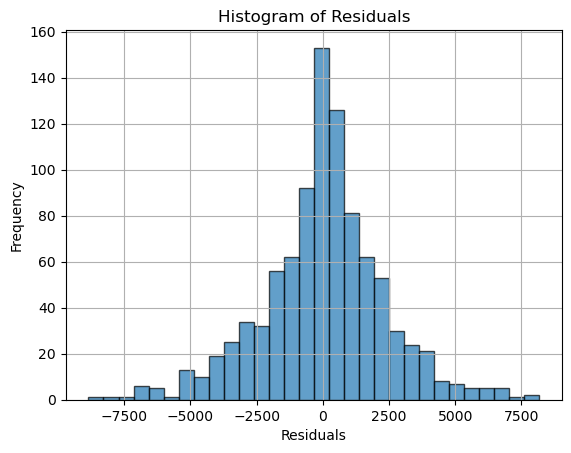

In [177]:
plt.hist(residuals_no_nan, bins=30, edgecolor='k', alpha=0.7)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Data preprocess

SCALE DATA (Z-score normalization)

In [178]:
from sklearn.preprocessing import StandardScaler

In [179]:

data = pd.DataFrame()
data['input'] = daily_output['initial'][105:]
data.index = date['datetime'][105:]


TEST AND TRAIN SPLIT

In [180]:
scaler = StandardScaler()
train_size = int(len(data) -104)
train_data_1 = data.iloc[:-104]
test_data_1 = data.iloc[-104:]
train_data = scaler.fit_transform(train_data_1)
test_data_n = scaler.transform(test_data_1)


CONVERT TO 32bit float for RAM saving

In [181]:
input = train_data.astype(np.float32)

## EXTERNAL REGRESSOR, CLEAR SKY IRRADIANCE

In [182]:
import pvlib

In [183]:
latitude = 36.73  # Fresno
longitude = -119.78
altitude = 93  # meters

In [184]:
time = pd.date_range(start='1998-01-01', end='2022-12-31', freq='30min', tz='America/Los_Angeles')

In [185]:
solpos = pvlib.solarposition.get_solarposition(
    time=time,
    latitude=latitude,
    longitude=longitude,
    altitude=altitude,
)

In [186]:
clear_sky = pvlib.clearsky.ineichen(
    solpos['apparent_zenith'],
    solpos['azimuth'],
    linke_turbidity=3,  # You can adjust this turbidity value
    altitude=altitude,
)

In [187]:
ghi = clear_sky['ghi'].resample('W').mean()
dni = clear_sky['dni'].resample('W').mean()
dhi = clear_sky['dhi'].resample('W').mean()
len(ghi)

1305

In [189]:
ghi_TR = pd.DataFrame(ghi[105:-104])
ghi_TS = pd.DataFrame(ghi[-104:])
exog_train = ghi_TR.values.reshape(-1, 1)
exog_test = ghi_TS.values.reshape(-1, 1)

## Fitting SARIMAX model

In [190]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [268]:
model = SARIMAX(input, 
                order=(4, 1, 1), 
                seasonal_order=(1, 1, 1, 52), 
                enforce_stationarity=True,
                force_invertibility=True)
results = model.fit()

c:\Users\naoki\miniforge3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['force_invertibility']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


## ANALYZING Results

In [263]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1096
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood               -1473.645
Date:                            Sun, 29 Dec 2024   AIC                           2949.289
Time:                                    11:45:38   BIC                           2954.239
Sample:                                         0   HQIC                          2951.167
                                           - 1096                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9880      0.036     27.808      0.000       0.918       1.058
Ljung-Box (L1) (Q):                

ARIMA(4,1) = 


In [264]:
in_sample = results.predict(start=0, end=len(train_data),exog=exog_train[0]) 
out_sample = results.forecast(steps=104,exog=exog_test)

in_sample = pd.DataFrame(in_sample, index=data.iloc[:-103].index)
out_sample = pd.DataFrame(out_sample, index=data.iloc[-104:].index)


in_sample = scaler.inverse_transform(in_sample)
out_sample = scaler.inverse_transform(out_sample)

In [265]:
in_sample = pd.DataFrame(in_sample, index=data.iloc[:-103].index)
out_sample = pd.DataFrame(out_sample, index=data.iloc[-104:].index)


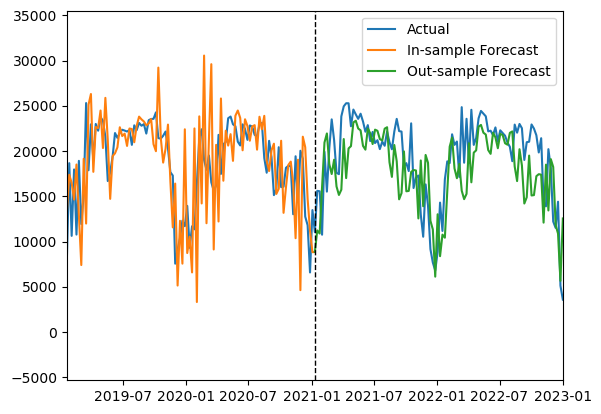

In [266]:
plt.plot(data['input'], label='Actual')
plt.plot(in_sample, label='In-sample Forecast')
plt.plot(out_sample, label='Out-sample Forecast')
plt.legend()
plt.axvline(in_sample.index[-1], color='black', linewidth=1, linestyle='--')
plt.xlim([in_sample.index[-104], out_sample.index[-1]])
plt.show()

In [267]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming 'results' is your fitted SARIMA model and 'train_data' is your original training data
# Get in-sample predictions
in_sample_predictions = results.predict(start=0, end=len(test_data)-1)


# Calculate AIC and BIC
aic = results.aic
bic = results.bic

# Calculate MAE
mae = mean_absolute_error(test_data, out_sample)

# Calculate MSE
mse = mean_squared_error(test_data, out_sample)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAPE
mape = (mae / np.mean(test_data)) * 100

# Calculate R-squared


print(f"AIC: {aic}")
print(f"BIC: {bic}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")


AIC: 2949.2892607178146
BIC: 2954.2391171728154
MAE: 3150.8300495526655
MSE: 15437216.429386327
RMSE: 3929.022324877568
MAPE: 16.308704567582126


In [260]:
residuals_in = results.resid
residuals_in_sq = residuals_in ** 2
residuals_out = test_data.values - out_sample.values
residuals_out_sq = residuals_out ** 2

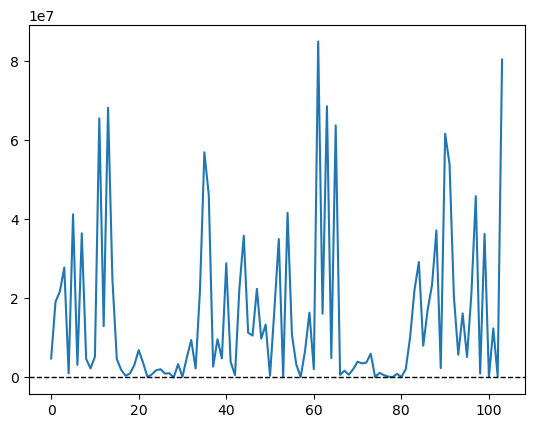

In [261]:
plt.plot(residuals_out_sq, label='In-sample Residuals')

plt.axhline(0, color='black', linewidth=1, linestyle='--')

In [203]:
sarima_forecast = results.get_forecast(steps=len(test_data),exog=exog_test)
mean_forecast = sarima_forecast.predicted_mean

c:\Users\naoki\miniforge3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['force_invertibility']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


## GARCH ON RESIDUALS

In [204]:
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


Augmented Dickey-Fuller Test:
Test Statistic: -9.9442
p-value: 0.0000
Critical Values:
	1%: -3.4365
	5%: -2.8642
	10%: -2.5682

KPSS Test:
Test Statistic: 0.2890
p-value: 0.1000


C:\Users\naoki\AppData\Local\Temp\ipykernel_30372\3749740444.py:47: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries.dropna())


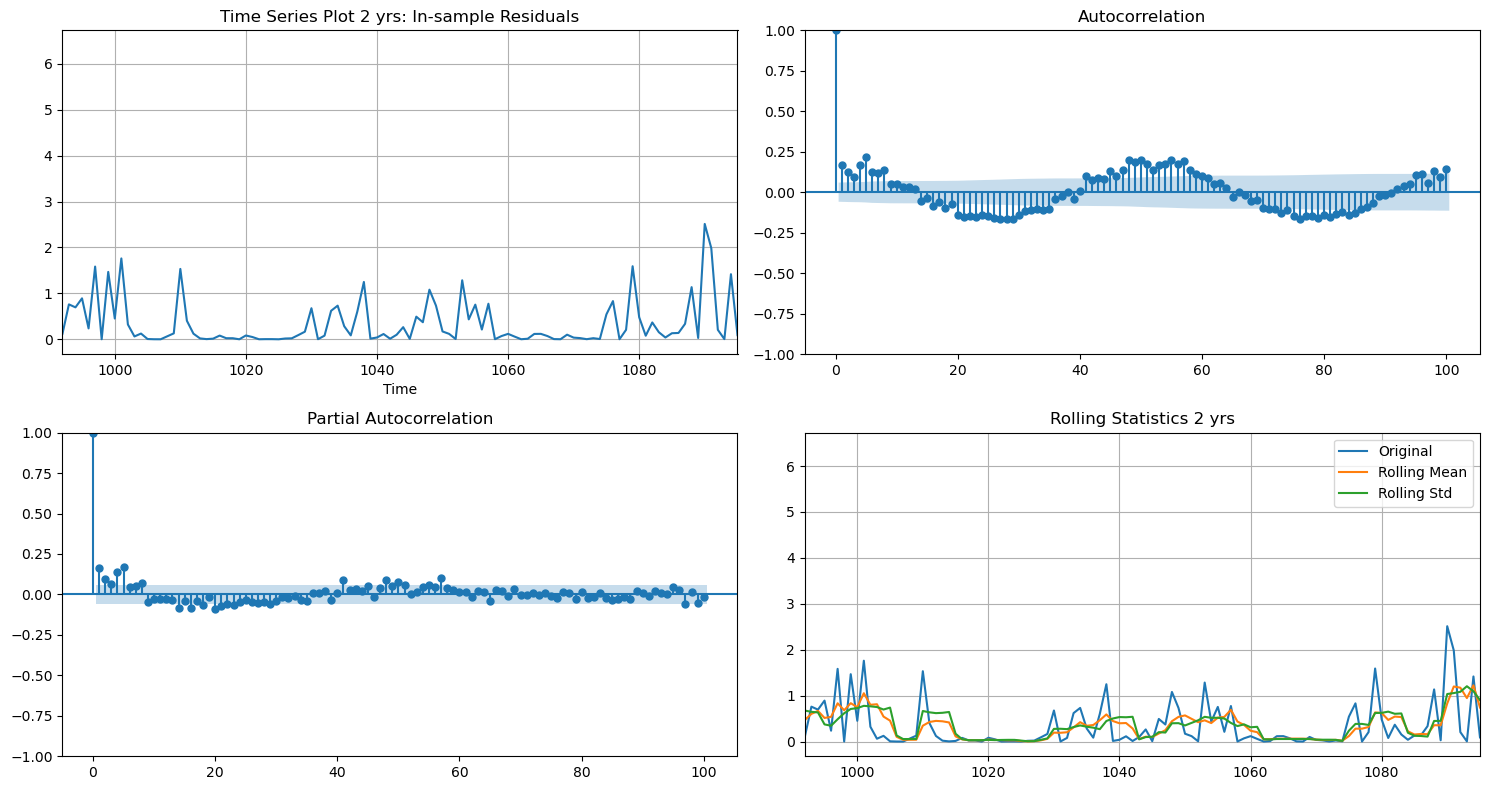

In [205]:
check_stationarity(pd.Series(residuals_in_sq), 'In-sample Residuals',lag=100)

In [206]:
model = arch_model(residuals_in, vol='Garch', p=5, q=52)

In [207]:
model_fit = model.fit(disp='off')

In [208]:
print(model_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -866.503
Distribution:                  Normal   AIC:                           1851.01
Method:            Maximum Likelihood   BIC:                           2145.97
                                        No. Observations:                 1096
Date:                Sun, Dec 29 2024   Df Residuals:                     1095
Time:                        11:30:40   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0126  3.591e-02     -0.352      0.725 

## Predict using garch, SARIMA

In [209]:
forecast_horizon = 52
total_forecast_steps = 104
variance_forecast = []

for i in range(0, total_forecast_steps, forecast_horizon):
    garch_forecast = model_fit.forecast(horizon=forecast_horizon)
    variance_forecast.extend(garch_forecast.variance.values[-1, :])

In [210]:
variance_forecast = variance_forecast[:total_forecast_steps]

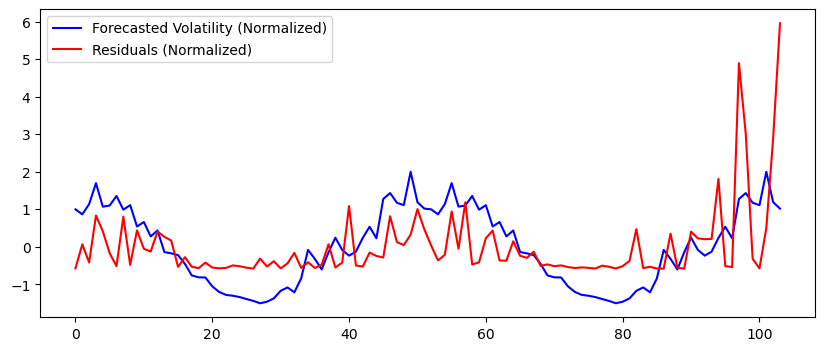

In [217]:
# Normalize residuals_out and forecasted volatility
residuals_out_normalized = (residuals_out - np.mean(residuals_out)) / np.std(residuals_out)


rolling_mean = pd.Series(residuals_out_normalized.flatten()).rolling(window=10).mean()
rolling_std = pd.Series(residuals_out_normalized.flatten()).rolling(window=10).std()

plt.figure(figsize=(10, 4))



# Normalize residuals_out_sq and variance_forecast
residuals_out_sq_normalized = (residuals_out_sq - np.mean(residuals_out_sq)) / np.std(residuals_out_sq)
variance_forecast_normalized = (variance_forecast - np.mean(variance_forecast)) / np.std(variance_forecast)
plt.plot(variance_forecast_normalized, label='Forecasted Volatility (Normalized)', color='blue')
plt.plot(residuals_out_sq_normalized, label='Residuals (Normalized)', color='red')
plt.legend()
plt.show()

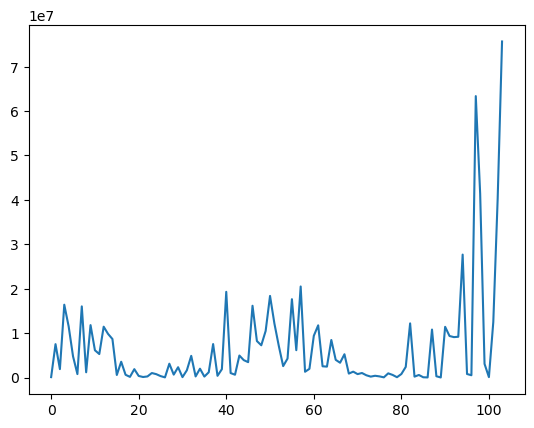

In [220]:
plt.plot(residuals_out_sq)

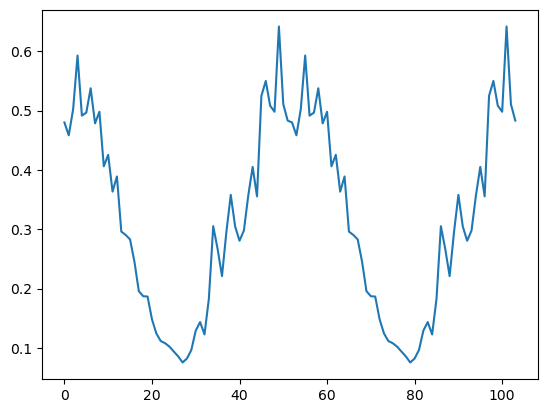

In [219]:
plt.plot(variance_forecast)

In [1196]:
forecasted_volatility_normalized

array([ 1.34915156,  0.90217342,  0.91314146,  1.51644027,  1.05923346,
        1.06760596,  0.95558717,  1.11461556,  0.90274518,  0.70579945,
        0.57971738,  0.6225761 ,  0.38453215,  0.1520925 ,  0.10012401,
       -0.10080213, -0.31917678, -0.51108772, -0.61398818, -0.82460199,
       -1.0140173 , -1.17496784, -1.29615692, -1.38823329, -1.51980995,
       -1.6248066 , -1.69285638, -1.72981673, -1.77455674, -1.56691661,
       -1.2592013 , -1.28696086, -1.11058455, -0.39533632, -0.2763768 ,
       -0.40103342, -0.13255494,  0.12551   ,  0.009695  , -0.12733732,
       -0.03648767,  0.11223429,  0.3082441 ,  0.20344675,  0.74554041,
        1.19139863,  1.08541875,  1.02859967,  1.4370355 ,  1.40468784,
        1.10196315,  1.09835868,  1.34915156,  0.90217342,  0.91314146,
        1.51644027,  1.05923346,  1.06760596,  0.95558717,  1.11461556,
        0.90274518,  0.70579945,  0.57971738,  0.6225761 ,  0.38453215,
        0.1520925 ,  0.10012401, -0.10080213, -0.31917678, -0.51

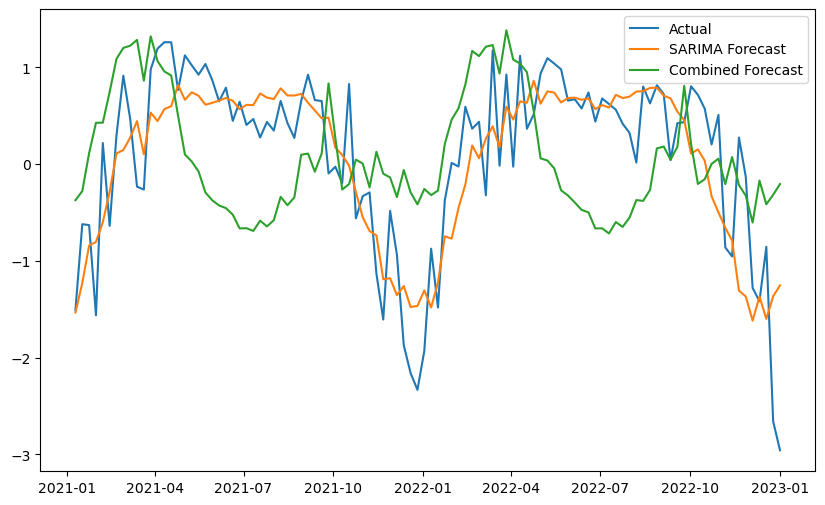

In [1197]:
plt.figure(figsize=(10, 6))
plt.plot(data[-104:].index, test_data_n, label='Actual')
plt.plot(data[-104:].index, mean_forecast, label='SARIMA Forecast')
plt.plot(data[-104:].index, combined_forecast, label='Combined Forecast')
plt.legend()
plt.show()